Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
_______________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 224, 224, 3)


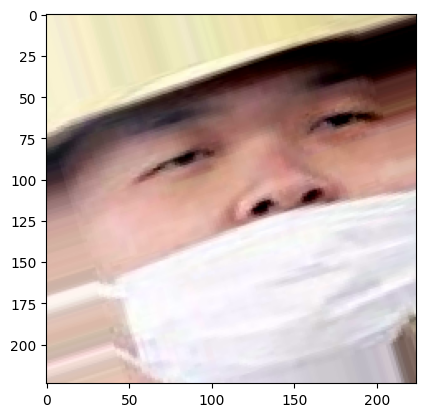

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 224, 224, 3)


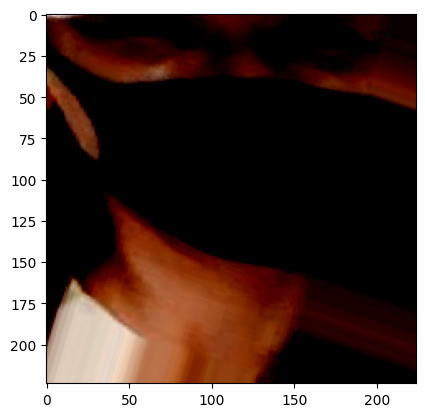

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 224, 224, 3)


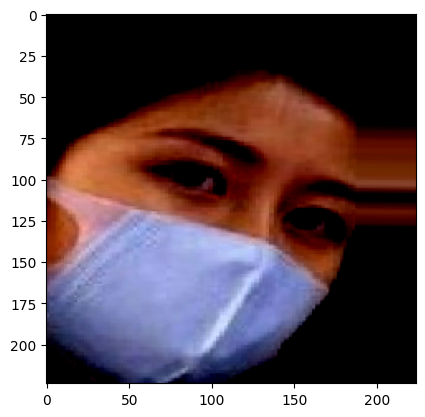

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 224, 224, 3)


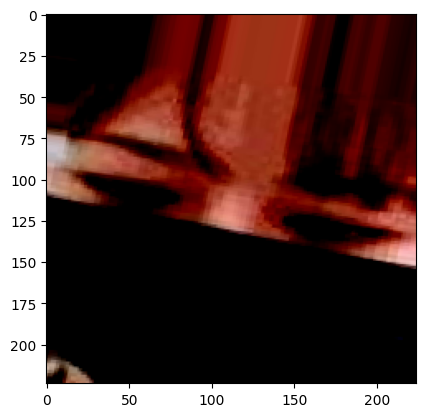

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 224, 224, 3)


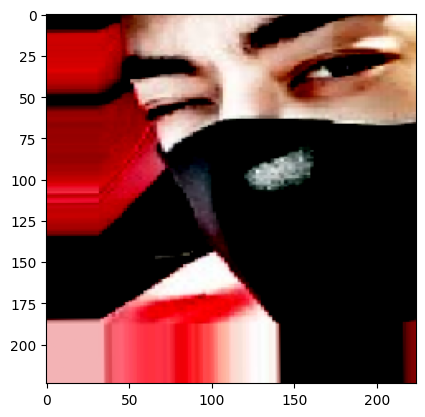

Epoch 1/100
24/24 [==============================] - 25s 1s/step - loss: 0.6097 - accuracy: 0.6746 - val_loss: 0.2582 - val_accuracy: 0.9630
Epoch 2/100
24/24 [==============================] - 24s 1s/step - loss: 0.2670 - accuracy: 0.9008 - val_loss: 0.1301 - val_accuracy: 0.9788
Epoch 3/100
24/24 [==============================] - 23s 969ms/step - loss: 0.2008 - accuracy: 0.9259 - val_loss: 0.0877 - val_accuracy: 0.9894
Epoch 4/100
24/24 [==============================] - 23s 967ms/step - loss: 0.1134 - accuracy: 0.9656 - val_loss: 0.0700 - val_accuracy: 0.9894
Epoch 5/100
24/24 [==============================] - 26s 1s/step - loss: 0.0974 - accuracy: 0.9683 - val_loss: 0.0449 - val_accuracy: 0.9947
Epoch 6/100
24/24 [==============================] - 25s 1s/step - loss: 0.0849 - accuracy: 0.9749 - val_loss: 0.0475 - val_accuracy: 0.9947
Epoch 7/100
24/24 [==============================] - 24s 1s/step - loss: 0.0656 - accuracy: 0.9788 - val_loss: 0.0396 - val_accuracy: 0.9947
Epoch 8

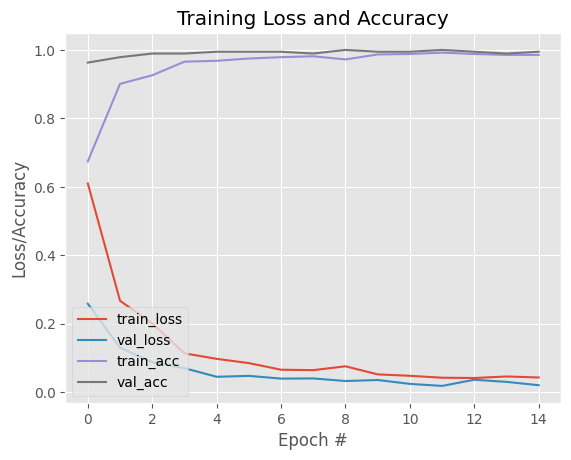

In [5]:
import sys
from imutils import paths
import os
import numpy as np
from tensorflow.keras import callbacks, Sequential
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sys.path.append("../")

PATH_TO_IMAGE = "../dataset"
MODELS_PATH = "../models_test"
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 32


def collect_images_and_labels(path_to_images):
    # in seguito, usare https://keras.io/api/preprocessing/image/
    """
        :param path_to_images should be the root folder, in which there is a folder for each label, and the folder's name is
        the label itself
        :return: a list with images and a list with labels
        """
    data = []
    labels = []

    for img_path in list(paths.list_images(path_to_images)):
        # extract the class label from the filename
        label = img_path.split(os.path.sep)[-2]

        # load the input image as (224x224) and preprocess it
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

    return data, labels


def preprocess_labels(labels):
    """
    :param labels: list of string
    :return: np array of 0/1
    """
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def tts_split(data, labels):
    (x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.10, stratify=labels,
                                                          random_state=42)
    (x_train, x_test, y_train, y_test) = (np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test))
    
    return x_train, x_test, y_train, y_test


def load_base_mobilenetv2():
    # load the MobileNetV2 network, left off the head FC layer sets
    dim = (240, 240)
    channel = (3, )
    input_shape = dim + channel
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = Sequential(baseModel)
    headModel.add(AveragePooling2D(pool_size=(7, 7), data_format='channels_last'))
    headModel.add(Flatten(name="flatten"))
    headModel.add(Dense(128, activation="relu"))
    headModel.add(Dropout(0.5))
    headModel.add(Dense(2, activation="softmax"))

    # place the head FC model on top of the base model
    model = headModel  # Model(inputs=baseModel.input, outputs=headModel)
    print(model.summary())

    # freeze layers of base models so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False

    return model


def plot_train_history(H):
    # plot the training loss and accuracy
    N = len(H.epoch)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(os.path.join(MODELS_PATH, "training_plot.png"))
    report_df = pd.DataFrame({
        "loss": H.history["loss"],
        "val_accuracy": H.history["val_accuracy"],
        "val_loss": H.history["val_loss"],
        "accuracy": H.history["accuracy"]
    })
    plt.show()
    report_df.to_csv(os.path.join(MODELS_PATH, "model_report_test.csv"))


def fine_tune_model():
    data, labels = collect_images_and_labels(PATH_TO_IMAGE)
    labels = preprocess_labels(labels)
    x_train, x_test, y_train, y_test = tts_split(data, labels)
    
    model = load_base_mobilenetv2()

    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2)
    

    train_generator = aug.flow(x_train, y_train, batch_size=BS, save_format='png',subset="training")
    val_generator = aug.flow(x_train, y_train, batch_size=BS, subset="validation")
    
    for _ in range(5):
        img, label = train_generator.next()
        print(img.shape)   #  (1,256,256,3)
        plt.imshow(img[0])
        plt.show()
        

        
    # compile our model
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # add callbacks
    model_callbacks = [callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=0, mode='auto'),
                       callbacks.ModelCheckpoint(
                           filepath=os.path.join(MODELS_PATH, 'weights-{epoch:02d}-{accuracy:.2f}.hdf5'),
                           save_weights_only=True,
                           monitor='accuracy',
                           mode='max',
                           save_best_only=True)]

    # train the head of the network
    H = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.n / float(BS))),
        validation_data=val_generator,
        validation_steps=int(np.ceil(val_generator.n / float(BS))),  # int(np.ceil(len(x_test) / BS)),
        epochs=EPOCHS,
        callbacks=model_callbacks
    )

    # make predictions on the testing set
    id_pred = model.predict(x_test, batch_size=BS)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    id_pred = np.argmax(id_pred, axis=1)

    # show a nicely formatted classification report
    print(classification_report(y_test.argmax(axis=1), id_pred,
                                target_names=["Bermasker", "Tidak_Bermasker"]))

    plot_train_history(H)
    # serialize the model to disk
    model.save(os.path.join(MODELS_PATH, "mask_mobilenet_test.h5"), save_format="h5")


if __name__ == '__main__':
    fine_tune_model()


In [105]:
import requests
from io import BytesIO

from PIL import Image
import numpy as np

In [106]:
# Parameters
input_size = (224,224)

#define input shape
channel = (3,)
input_shape = input_size + input_size

#define labels
labels = ['mask', 'no_mask']

In [107]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [108]:
from tensorflow.keras.models import load_model

In [109]:
# ada 2 cara load model, jika cara pertama berhasil maka bisa lasngusng di lanjutkan ke fungsi prediksi

MODEL_PATH = '../models/mask_mobilenet.h5'
model = load_model(MODEL_PATH,compile=False)

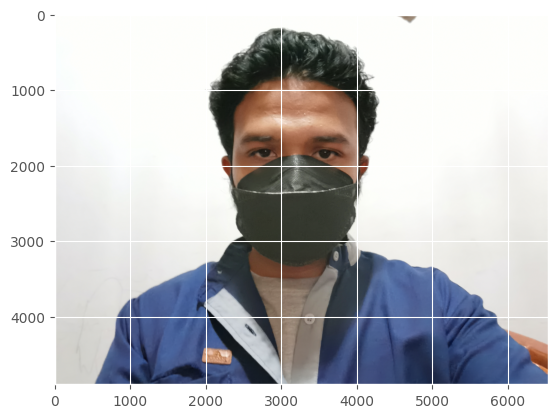

mask 0.9967379


In [190]:
# read image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('datatest/zd4.jpg')
imgplot = plt.imshow(img)
plt.show()

# read image
im = Image.open('datatest/zd4.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )